In [ ]:
!pip install pgeocode seaborn plotly opencv-python imageio scikit-image kaleido

In [ ]:
!wget "http://pub.farzaneh21.ir:8000/archive.zip"
!unzip archive.zip
!mkdir plots

In [1]:
# Base Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
import scipy
import argparse
import plotly.graph_objects as go
import pgeocode
import plotly.express as px
from IPython.display import Image

# Image processing
import cv2
import imageio
import skimage
import skimage.io
import skimage.transform
from skimage.color import rgb2gray

# Tensorflow
from sklearn.preprocessing import LabelBinarizer

#Sklearn
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN as dbs
from sklearn.model_selection import GridSearchCV

RSEED=42
bee_imgs = "archive/bee_imgs/bee_imgs/"
sns.set(font='sans-serif', font_scale=1)

# Bee Data Health Status
| Variable | Definition | Key |
|---|---|---|
| datetime | Date of the Measurment | Year-Month-Day Hour:Minute:Second|
|file| Filename of the Image| filename.png|
|location|Location of the Beehive |City, State, Country |
|zip code| Zipcode of the City|- |
|subspecies| Subspecies of the Honey Bee| Italian, Russian, Carniolan, Mixed, -1, VSH Italian, Western|
|health| Health Status of the Beehive| Varroa mites and Hive Beetles, Healthy, Hive Being Robbed, Ant Problems, Missing Queen|
|pollen_carrying| Boolean if the Honey Bee on the Image is carrying Pollen| False or True|
|caste| Caste of the Honey Bee on the Image| Caste (in this case only workers)|

In [49]:
bee_data = pd.read_csv('archive/bee_data.csv',
                       parse_dates={'datetime': [1, 2]},
                       dtype={'subspecies': 'category','health': 'category','caste': 'category'})

In [50]:
bee_data.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [51]:
bee_data.columns = bee_data.columns.str.replace(' ', '_')

# EDA for the Bee images for Health detection

In [52]:
bee_data.describe()

,zip_code
count,5172.000000
mean,68599.910480
std,27101.954146
min,3431.000000
25%,50315.000000
50%,77511.000000
75%,95070.000000
max,95124.000000


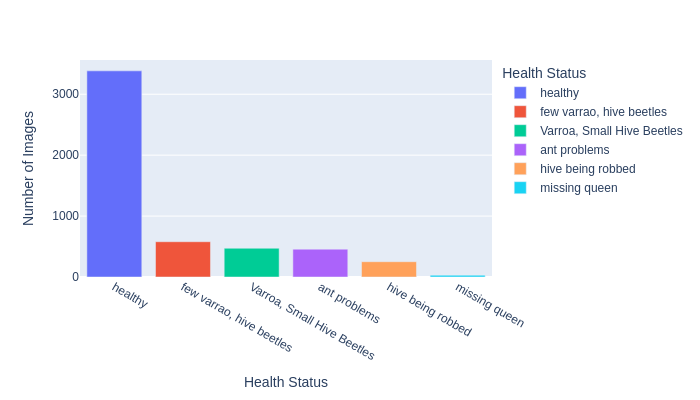

In [53]:
bee_data_health = bee_data.health.value_counts().reset_index()
bee_data_health.columns = ['Health Status', 'Number of Images']
fig = px.bar(bee_data_health, x='Health Status', y='Number of Images',
             hover_data=['Number of Images'], color='Health Status',
             labels={'Number of Images': 'Number of Images', 'Health Status': 'Health Status'},
             height=400)
#fig.show()
fig.write_image("plots/fig1.png")
Image("plots/fig1.png")

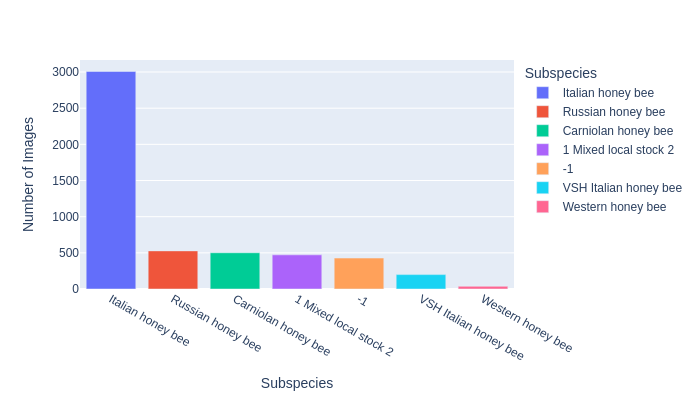

In [54]:
bee_data_sub = bee_data.subspecies.value_counts().reset_index()
bee_data_sub.columns = ['Subspecies', 'Number of Images']

fig = px.bar(bee_data_sub, x='Subspecies', y='Number of Images',
             hover_data=['Number of Images'], color='Subspecies',
             labels={'Number of Images': 'Number of Images', 'Subspecies': 'Subspecies'},
             height=400)

#fig.show()
fig.write_image("plots/fig2.png")
Image("plots/fig2.png")

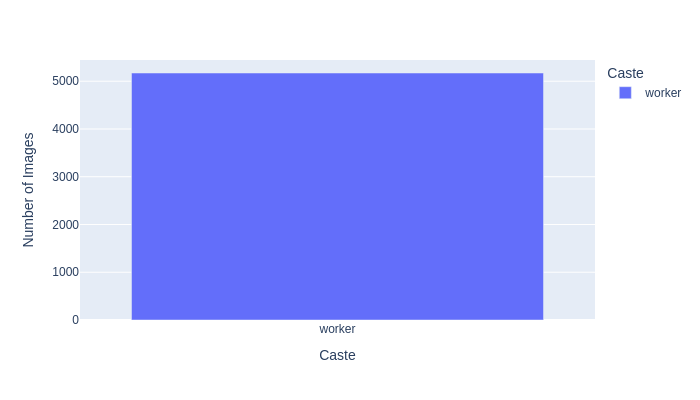

In [55]:
bee_data_caste = bee_data.caste.value_counts().reset_index()
bee_data_caste.columns = ['Caste', 'Number of Images']

# Create the bar plot
fig = px.bar(bee_data_caste, x='Caste', y='Number of Images',
             hover_data=['Number of Images'], color='Caste',
             labels={'Number of Images': 'Number of Images', 'Caste': 'Caste'},
             height=400)
#fig.show()
fig.write_image("plots/fig3.png")
Image("plots/fig3.png")

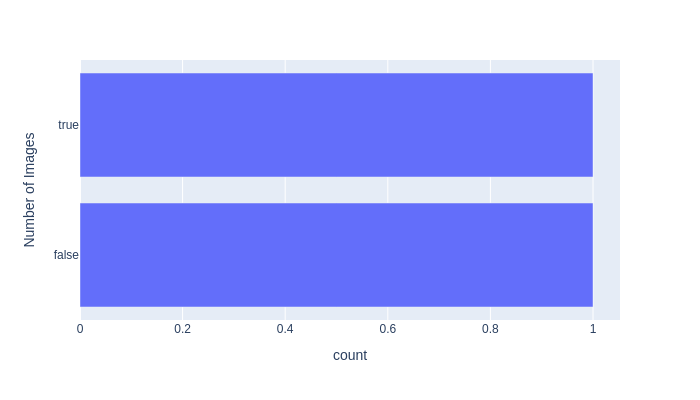

In [56]:
bee_data_pollen = bee_data.pollen_carrying.value_counts().reset_index()
bee_data_pollen.columns = ['Pollen Carrying', 'Number of Images']
fig = px.bar(bee_data_pollen, y='Pollen Carrying',
             hover_data=['Pollen Carrying'],
             labels={'Pollen Carrying':'Number of Images', 'index': 'Pollen Carrying'}, height=400)
#fig.show()
fig.write_image("plots/fig4.png")
Image("plots/fig4.png")

### Creating Dummies

In [57]:
bee_data_dum = bee_data.copy()

#### Subspecies

In [58]:
subspecies_dummies = pd.get_dummies(bee_data_dum.subspecies, drop_first=True)

In [59]:
subspecies_dummies.columns = subspecies_dummies.columns.str.replace(' ', '_')

#### Pollen Carrying

In [60]:
pollen_dummies = pd.get_dummies(bee_data_dum.pollen_carrying, drop_first=True, prefix = 'pollen_')

#### Health

In [61]:
health_dummies = pd.get_dummies(bee_data_dum.health, drop_first=True)

In [62]:
health_dummies.columns = health_dummies.columns.str.replace(' ', '_')

In [63]:
health_dummies.missing_queen.value_counts()

,missing_queen
0,5143
1,29


In [64]:
health_dummies.hive_being_robbed.value_counts()

,hive_being_robbed
0,4921
1,251


#### Location

In [65]:
location_dummies = pd.get_dummies(bee_data_dum.location, drop_first=True)

In [66]:
location_dummies.columns = location_dummies.columns.str.replace(' ', '_')

#### zip code

In [67]:
zip_dummies = pd.get_dummies(bee_data_dum.zip_code, drop_first=True)

#### caste

In [68]:
caste_dummies = pd.get_dummies(bee_data_dum.caste)

#### Create new data frame with dummies

In [69]:
drop_columns = [
    'health', 'subspecies', 'pollen_carrying', 'caste', 'location', 'zip_code'
]
bee_data_dum.drop(drop_columns, axis=1, inplace=True)

In [70]:
bee_data_dum = pd.concat([
    bee_data_dum, health_dummies, pollen_dummies, subspecies_dummies,
    caste_dummies, zip_dummies, location_dummies
],
                         axis=1)
bee_data_dum.head()

,datetime,file,ant_problems,"few_varrao,_hive_beetles",healthy,hive_being_robbed,missing_queen,pollen__True,1_Mixed_local_stock_2,Carniolan_honey_bee,...,77511,95070,95124,"Athens,_GA,_USA","Athens,_Georgia,_USA","Des_Moines,_IA,_USA","Keene,_NH,_USA","New_Orleans,_LA,_USA","San_Jose,_CA,_USA","Saratoga,_CA,_USA"
0,2018-08-28 16:07:00,041_066.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2018-08-28 16:07:00,041_072.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2018-08-28 16:07:00,041_073.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,2018-08-28 16:07:00,041_067.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2018-08-28 16:07:00,041_059.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Heatmaps

In [71]:
bee_data_dum.head(5)

,datetime,file,ant_problems,"few_varrao,_hive_beetles",healthy,hive_being_robbed,missing_queen,pollen__True,1_Mixed_local_stock_2,Carniolan_honey_bee,...,77511,95070,95124,"Athens,_GA,_USA","Athens,_Georgia,_USA","Des_Moines,_IA,_USA","Keene,_NH,_USA","New_Orleans,_LA,_USA","San_Jose,_CA,_USA","Saratoga,_CA,_USA"
0,2018-08-28 16:07:00,041_066.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2018-08-28 16:07:00,041_072.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2018-08-28 16:07:00,041_073.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,2018-08-28 16:07:00,041_067.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2018-08-28 16:07:00,041_059.png,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


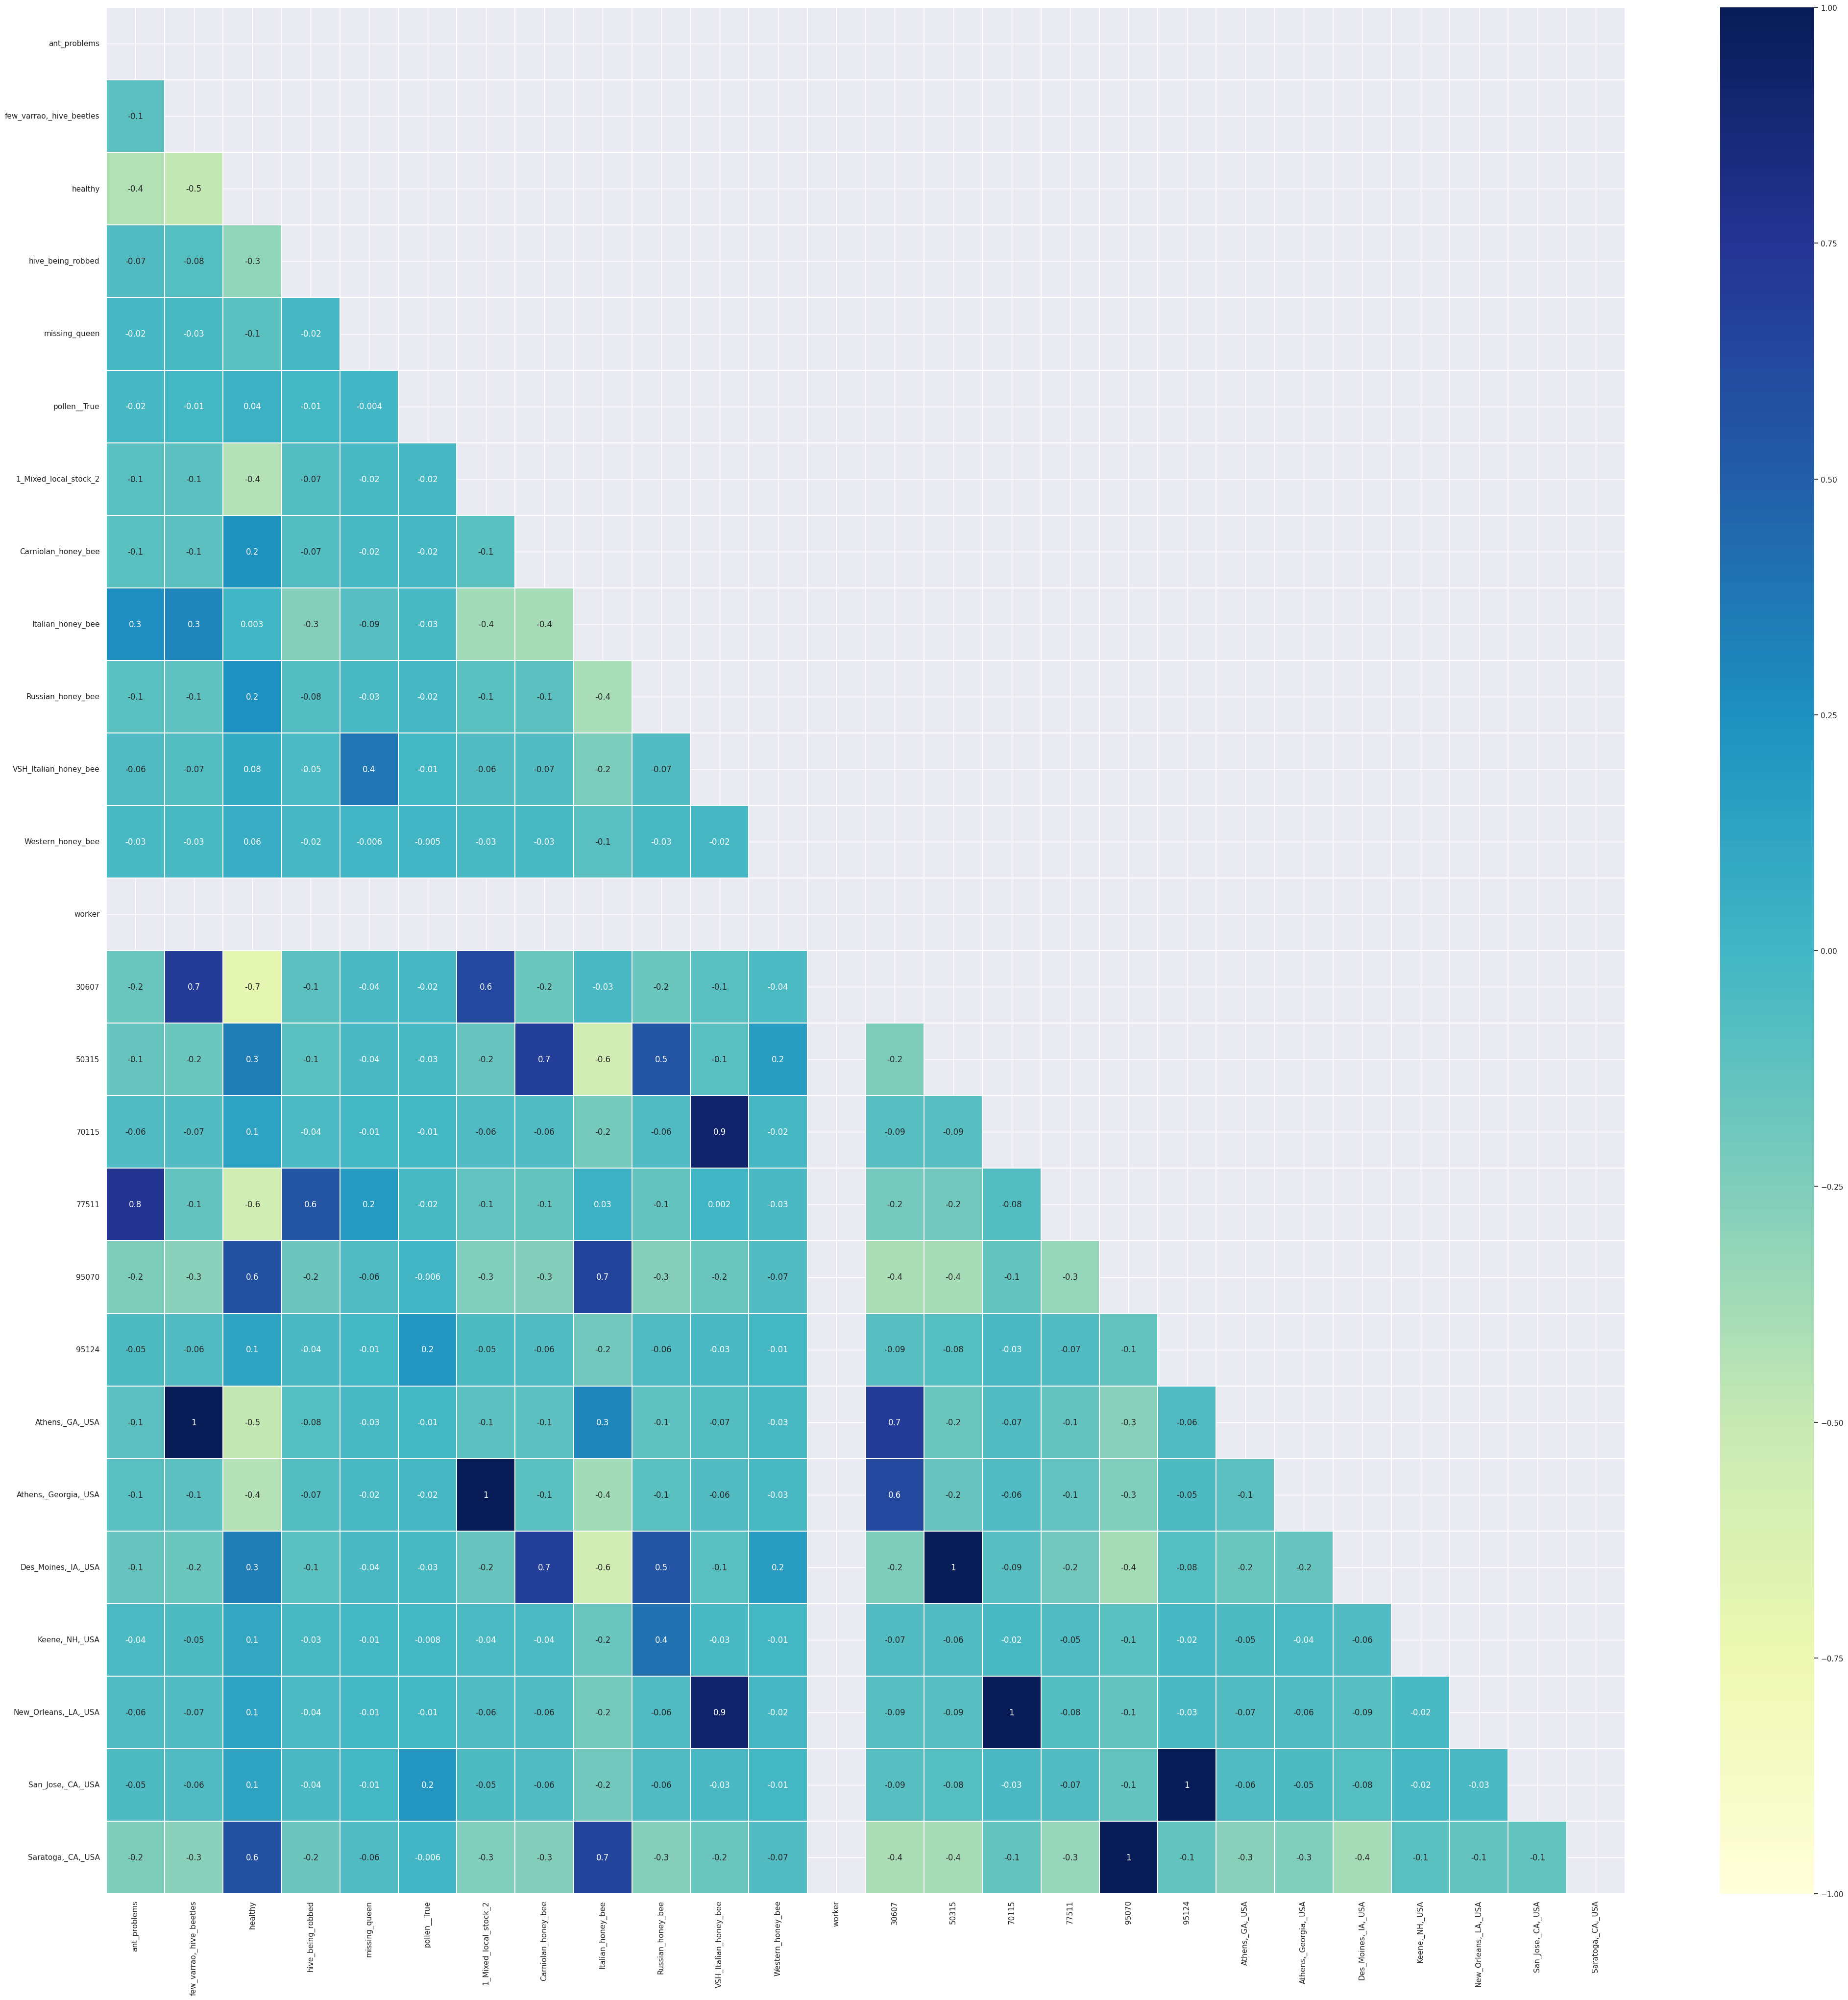

In [72]:
boolean_columns = bee_data_dum.select_dtypes(include=['bool']).columns
bee_data_dum[boolean_columns] = bee_data_dum[boolean_columns].astype(int)

# Select only numeric columns
numeric_columns = bee_data_dum.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Generate the upper triangular matrix
matrix = np.triu(correlation_matrix)

plt.subplots(figsize=(50, 50))
sns.heatmap(correlation_matrix,
            mask=matrix,
            annot=True,
            fmt='.1g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap='YlGnBu',
            linewidth=.1);

## Feature engineering
The categories 'few varrao, hive beetles' and 'Varroa, small hive beetles' in the column 'health' both detect Varroa mites and Hive beetles. That's why they will be combined in the next steps.

In [73]:
bee_data.health.unique()

['hive being robbed', 'healthy', 'few varrao, hive beetles', 'ant problems', 'missing queen', 'Varroa, Small Hive Beetles']
Categories (6, object): ['Varroa, Small Hive Beetles', 'ant problems', 'few varrao, hive beetles', 'healthy',
                         'hive being robbed', 'missing queen']

In [74]:
new_cat = {
    'few varrao, hive beetles': 'varroa and hive beetles',
    'Varroa, Small Hive Beetles': 'varroa and hive beetles'
}

bee_data.health.replace(new_cat, inplace=True)

In [75]:
bee_data.health.astype('category').dtype

CategoricalDtype(categories=['ant problems', 'varroa and hive beetles', 'healthy',
                  'hive being robbed', 'missing queen'],
, ordered=False)

In [76]:
index_num = bee_data[bee_data['health'] == 'missing queen'].index

In [42]:
# Do not remove missing queen cat
# bee_data.drop(index_num , inplace=True)

## Looking at the pictures

In [90]:
import os
import cv2
import numpy as np
import albumentations as A
from pathlib import Path

augmentations_per_image = 5

transform = A.Compose([
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.RandomBrightnessContrast(p=0.4),
        A.RandomScale(scale_limit=0.2, p=0.4),
        A.Rotate(limit=30, p=0.5)
    ])

# Directories (adjust if needed)
bee_img = bee_data[bee_data['health'] == 'missing queen']
for index, row in bee_img.iterrows():
    file_path = row['file']
    missing_queen_dir = bee_imgs + file_path
    # Augmentation pipeline
    image = cv2.imread(missing_queen_dir)
    for i in range(augmentations_per_image):
        augmented = transform(image=image)['image']
        save_path = os.path.join("/content/archive/cats/train/missing queen/", f"aug{i}_{file_path.split('/')[-1]}")
        cv2.imwrite(save_path, augmented)

<ipython-input-90-6235ec73de03>:11: DeprecationWarning:

Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.



<ipython-input-91-1453dd8726d8>:8: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



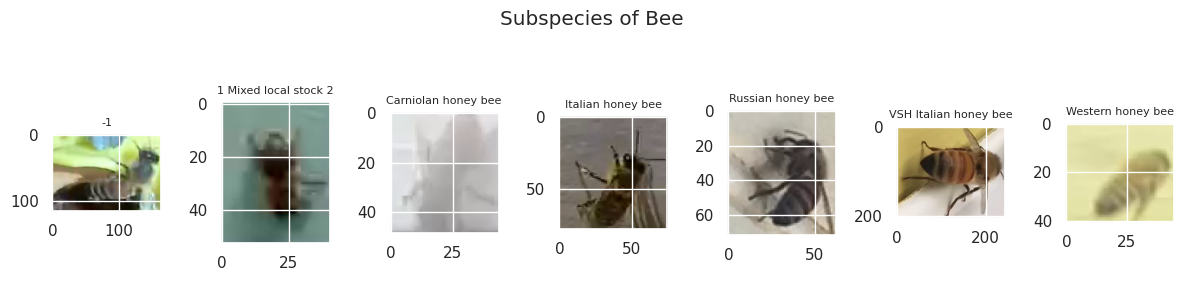

In [91]:
subspecies = bee_data['subspecies'].cat.categories
f, ax = plt.subplots(nrows=1, ncols=subspecies.size, figsize=(12, 3))
i = 0
for s in subspecies:
    if s == 'healthy':
        continue
    file = bee_imgs + bee_data[bee_data['subspecies'] == s].iloc[0]['file']
    im = imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=8)
    i += 1

plt.suptitle("Subspecies of Bee")
plt.tight_layout()
plt.show()

<ipython-input-92-9faaa536be1f>:8: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



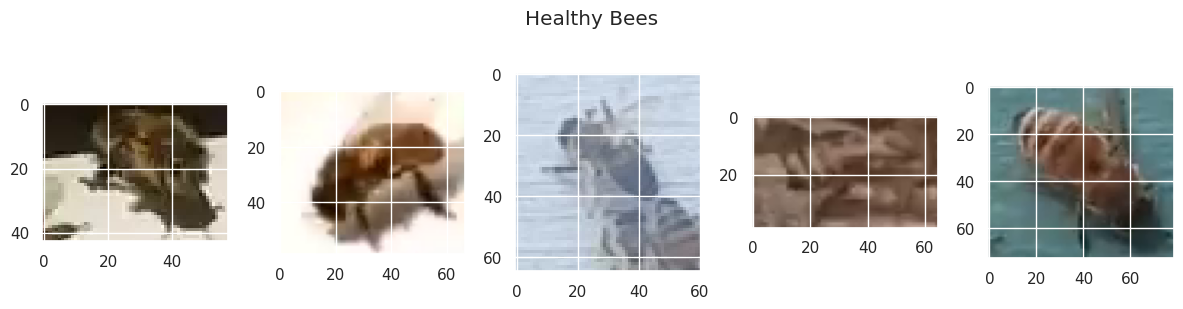

In [92]:
n = 5
healthy = bee_data[bee_data['health'] == 'healthy'].sample(n)

f, ax = plt.subplots(nrows=1, ncols=n, figsize=(12, 3))
# Read image of original size from disk, because bees['img'] contains resized numpy array
for i in range(0, 5):
    file = bee_imgs + healthy.iloc[i]['file']
    ax[i].imshow(imageio.imread(file))

plt.suptitle("Healthy Bees")
plt.tight_layout()
plt.show()

In [93]:
health_cats = set()
for d in bee_data.health:
    health_cats.add(d)

<ipython-input-94-9d2d6a4024d2>:7: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



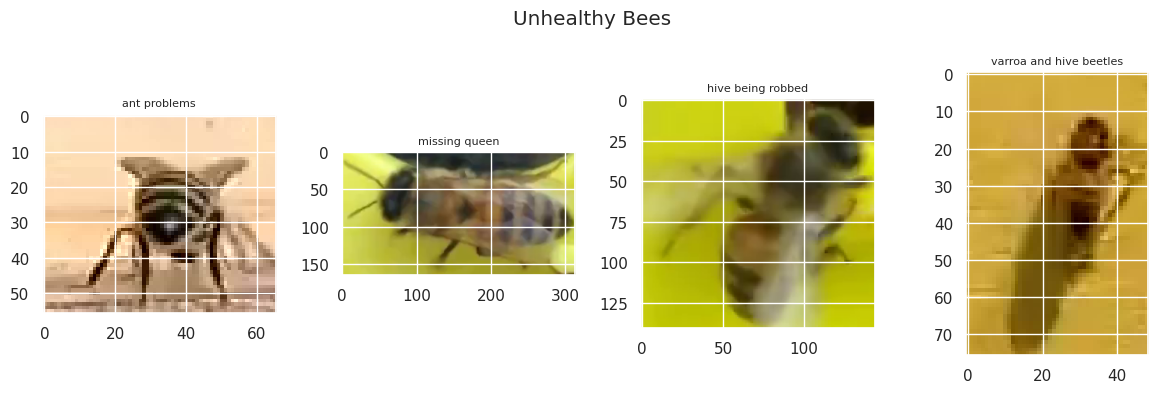

In [94]:
f, ax = plt.subplots(1, len(health_cats) - 1, figsize=(12, 4))
i = 0
for c in health_cats:
    if c == 'healthy':
        continue
    bee_img = bee_data[bee_data['health'] == c].sample(1).iloc[0]
    ax[i].imshow(imageio.imread(bee_imgs + bee_img['file']))
    ax[i].set_title(bee_img['health'], fontsize=8)
    i += 1

plt.suptitle("Unhealthy Bees")
plt.tight_layout()
plt.show()

### Images are of different sizes

In [95]:
def resize_img(file):
    """
    Read and resize img, adjust channels.
    """
    img = skimage.io.imread(bee_imgs + file)
    img = skimage.transform.resize(img, (100, 100), mode='reflect')
    img = rgb2gray(img[:, :, :3])
    img = img.flatten()
    return img

# Detection Model

In [96]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [97]:
from ultralytics import YOLO
model = YOLO("yolo11n-cls.pt")
results = model.train(data="/content/archive/cats", epochs=5, imgsz=64)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.52M/5.52M [00:00<00:00, 93.3MB/s]


Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/content/archive/cats, epochs=5, time=None, patience=100, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 5.35M/5.35M [00:00<00:00, 83.5MB/s]


AMP: checks passed ✅


train: Scanning /content/archive/cats/train... 4801 images, 0 corrupt: 100%|██████████| 4801/4801 [00:02<00:00, 1641.72it/s]

train: New cache created: /content/archive/cats/train.cache



val: Scanning /content/archive/cats/test... 514 images, 0 corrupt: 100%|██████████| 514/514 [00:00<00:00, 1483.39it/s]

val: New cache created: /content/archive/cats/test.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


        1/5     0.147G      2.324         16         64:   1%|▏         | 4/301 [00:01<01:20,  3.69it/s]

        1/5     0.149G      2.265         16         64:   3%|▎         | 10/301 [00:02<00:38,  7.65it/s]
100%|██████████| 755k/755k [00:00<00:00, 20.5MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.18it/s]

                   all      0.897          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.82it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 24.30it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.20it/s]

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 40.44it/s]

                   all      0.961          1



5 epochs completed in 0.037 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.2MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,533,710 parameters, 0 gradients, 3.2 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/archive/cats/train... found 4801 images in 6 classes ✅ 
val: None...
test: /content/archive/cats/test... found 514 images in 6 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 32.68it/s]


                   all      0.963          1
Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


In [102]:
model.names

{0: 'Varroa, Small Hive Beetles',
 1: 'ant problems',
 2: 'few varrao, hive beetles',
 3: 'healthy',
 4: 'hive being robbed',
 5: 'missing queen'}

In [103]:
from glob import glob
files = glob("/content/archive/cats/test/*/*.png")
corrects = []
predicted_class_names = []
for fi in files:
    pred = model.predict(fi, verbose=False)
    results = pred[0]
    predicted_class_idx = results.probs.top1  # Index of the class with the highest probability
    predicted_class_name = results.names[predicted_class_idx]
    predicted_class_names.append(predicted_class_name)
    if predicted_class_name == fi.split("/")[-2]:
        corrects.append(True)
    else:
        corrects.append(False)

In [104]:
len(corrects)

514

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(16, 16))
counter = 0
for i in range(len(corrects)):
    if not corrects[i]:  # Only if the prediction is incorrect
        axi = ax.flat[counter]
        img = cv2.imread(files[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axi.imshow(img, cmap='bone')
        axi.set(xticks=[], yticks=[])
        axi.set_ylabel(files[i].split("/")[-2],
                       color='black' if corrects[i] else 'red', fontsize=12)
        axi.set_xlabel(predicted_class_names[i], color='red', fontsize=12)
        counter += 1

fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);
fig.savefig("plots/yolov11.png")
Image("plots/yolov11.png")

## Bee Detection

In [1]:
!pip install --upgrade dataset-tools protobuf==3.19.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB

In [1]:
import dataset_tools as dtools

dtools.download(dataset='Bee Image Object Detection', dst_dir='/content/dataset-ninja/')

'/content/dataset-ninja/bee-image-object-detection.tar'

In [ ]:
import json
import os

# Define paths
ann_dir = "/content/dataset-ninja/bee-image-object-detection/ds/ann"  # Path to the directory containing your JSON annotations
img_dir = "/content/dataset-ninja/bee-image-object-detection/ds/img"  # Path to the directory containing your images
output_dir = "/content/dataset-ninja/bee-image-object-detection/ds/labels"  # Output directory for YOLO annotation TXT files
os.makedirs(output_dir, exist_ok=True)

# Process each JSON annotation file
for json_file in os.listdir(ann_dir):
    if json_file.endswith(".json"):
        # Load the JSON file
        with open(os.path.join(ann_dir, json_file), 'r') as f:
            data = json.load(f)

        # Image dimensions
        img_width = data["size"]["width"]
        img_height = data["size"]["height"]

        # Output TXT filename
        txt_filename = os.path.splitext(json_file)[0].replace(".jpeg", "") + ".txt"
        txt_filepath = os.path.join(output_dir, txt_filename)

        # Write YOLO annotations
        with open(txt_filepath, 'w') as txt_file:
            for obj in data["objects"]:
                class_id = 0  # YOLO class ID for "bee"
                x1, y1 = obj["points"]["exterior"][0]
                x2, y2 = obj["points"]["exterior"][1]

                # Convert to YOLO format (normalized center x, y, width, height)
                x_center = ((x1 + x2) / 2) / img_width
                y_center = ((y1 + y2) / 2) / img_height
                width = (x2 - x1) / img_width
                height = (y2 - y1) / img_height

                # Write to file
                txt_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


In [ ]:
!mkdir /content/images
!mkdir /content/labels
!mv /content/dataset-ninja/bee-image-object-detection/ds/img /content/images/train
!mv /content/dataset-ninja/bee-image-object-detection/ds/labels /content/labels/train

In [ ]:
!ls /content/images/train | head -2
!ls /content/labels/train | head -2

camp_IMG_7251_0.jpeg
camp_IMG_7251_116.jpeg
camp_IMG_7251_0.txt
camp_IMG_7251_116.txt


In [ ]:
!cat /content/labels/train/camp_IMG_7251_0.txt

0 0.158203 0.213889 0.116406 0.188889
0 0.279297 0.191667 0.132031 0.197222
0 0.044531 0.705556 0.062500 0.102778
0 0.108203 0.874306 0.077344 0.118056


In [ ]:
# Define the content of the YAML file as a string
yaml_content = """
path: /content  # dataset root dir
train: images/train
val: images/train
test:  # leave empty if not using
names:
  0: bee
"""

# Write the YAML content to a file
with open('/content/bee_dataset.yml', 'w') as file:
    file.write(yaml_content)


In [ ]:
from ultralytics import YOLO
model = YOLO("yolo11n.pt")
results = model.train(data="/content/bee_dataset.yml", epochs=100, imgsz=640)

Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/bee_dataset.yml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

train: Scanning /content/labels/train... 3044 images, 2 backgrounds, 0 corrupt: 100%|██████████| 3044/3044 [00:05<00:00, 517.21it/s]


train: New cache created: /content/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/labels/train.cache... 3044 images, 2 backgrounds, 0 corrupt: 100%|██████████| 3044/3044 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.32G      1.822      1.635      1.306         52        640: 100%|██████████| 191/191 [04:14<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [04:30<00:00,  2.82s/it]


                   all       3044      21240      0.795      0.801      0.846      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.37G      1.634      1.058      1.248         82        640: 100%|██████████| 191/191 [04:19<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [04:10<00:00,  2.60s/it]


                   all       3044      21240      0.808      0.804      0.862      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.85G      1.627     0.9661      1.257         53        640: 100%|██████████| 191/191 [03:52<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [04:35<00:00,  2.87s/it]


                   all       3044      21240      0.844      0.868      0.902      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.68G      1.612     0.8949      1.246         91        640: 100%|██████████| 191/191 [03:58<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [04:32<00:00,  2.84s/it]


                   all       3044      21240      0.864      0.869      0.916      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       3.4G      1.573      0.848      1.239         21        640: 100%|██████████| 191/191 [03:40<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [04:46<00:00,  2.98s/it]


                   all       3044      21240      0.884      0.893      0.934       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.28G      1.552     0.8194      1.229         45        640: 100%|██████████| 191/191 [03:51<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [04:42<00:00,  2.95s/it]


                   all       3044      21240       0.88      0.891      0.935      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.44G       1.54     0.7988      1.227         34        640: 100%|██████████| 191/191 [03:45<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [04:53<00:00,  3.05s/it]


                   all       3044      21240      0.884      0.892      0.935      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.13G      1.539     0.7851      1.226         89        640: 100%|██████████| 191/191 [03:49<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [05:02<00:00,  3.15s/it]


                   all       3044      21240      0.893      0.887      0.937      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.13G      1.505     0.7606      1.209        120        640: 100%|██████████| 191/191 [03:55<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [05:15<00:00,  3.29s/it]


                   all       3044      21240      0.909      0.875      0.945      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.21G      1.491     0.7459      1.199         34        640: 100%|██████████| 191/191 [03:56<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [05:08<00:00,  3.21s/it]


                   all       3044      21240      0.902      0.899      0.947      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.91G      1.474     0.7373       1.19        209        640:  39%|███▊      | 74/191 [01:57<03:22,  1.73s/it]

In [ ]:
model.names

In [ ]:
files = glob("/content/images/train/*.jpeg")
fi = files[0]

pred = model.predict(fi, verbose=False)
results = pred[0]
predicted_class_idx = results.probs.top1  # Index of the class with the highest probability
predicted_class_name = results.names[predicted_class_idx]
print(f"predicted class name is {predicted_class_name}")